**You can read in the kaggle data directly to google colab**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"


In [3]:
%cd /content/gdrive/My Drive/Kaggle


/content/gdrive/My Drive/Kaggle


In [4]:
#!kaggle datasets download -d andyczhao/covidx-cxr2

In [5]:
%cd COVID_contest

/content/gdrive/My Drive/Kaggle/COVID_contest


In [6]:
#!unzip \*.zip  && rm *.zip

**READ DATA, MAKE DATALOADER, VISUALIZE, ETC**

In [7]:
# import, start work here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [8]:
train_data = pd.read_csv('train.txt', delimiter = ' ', header = 0)

In [9]:
train_data.head()

,5,ARDSSevere.png,negative,cohen
0,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen
1,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen
2,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen
3,28,pneumocystis-pneumonia-2-PA.png,negative,cohen
4,38,F051E018-DAD1-4506-AD43-BE4CA29E960B.jpeg,negative,cohen


In [10]:
train_data.columns = ['patient','file','class','source']
train_data['class'] = [0 if i =='negative' else 1 for i in train_data['class']]

In [11]:
train_data.head()

,patient,file,class,source
0,25,acute-respiratory-distress-syndrome-ards-1.jpg,0,cohen
1,26,acute-respiratory-distress-syndrome-ards.jpg,0,cohen
2,27,ards-secondary-to-tiger-snake-bite.png,0,cohen
3,28,pneumocystis-pneumonia-2-PA.png,0,cohen
4,38,F051E018-DAD1-4506-AD43-BE4CA29E960B.jpeg,0,cohen


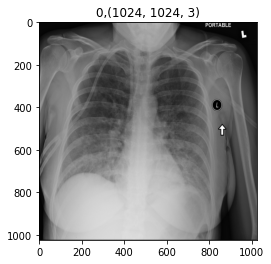

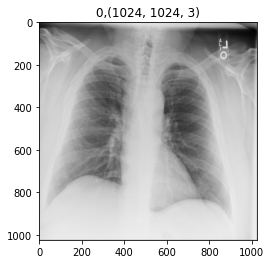

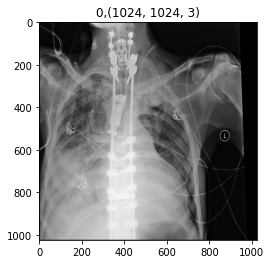

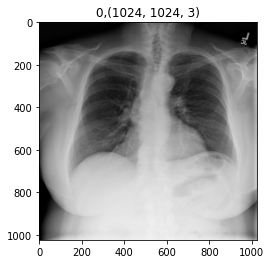

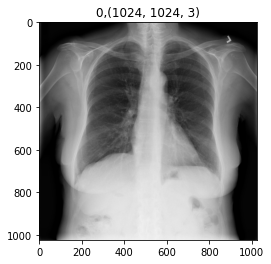

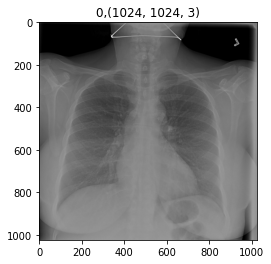

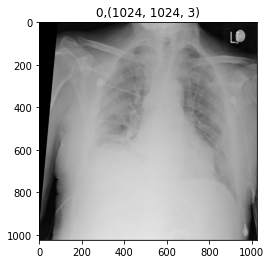

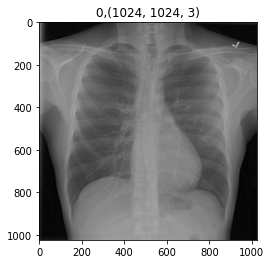

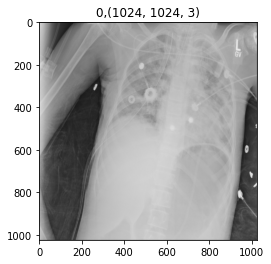

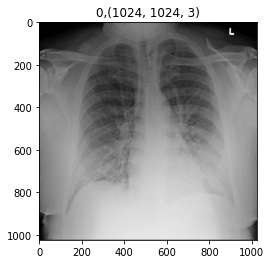

In [12]:
import glob

train_files = glob.glob('train/*')

for i in range(390,400):
  file = train_files[i].split('/')[-1]
  img = cv2.imread(train_files[i])
  label = train_data.loc[train_data['file'] == file]['class'].values[0]
  plt.imshow(img)
  plt.title("{},{}".format(label, img.shape))
  plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00beec7dd0>]],
      dtype=object)

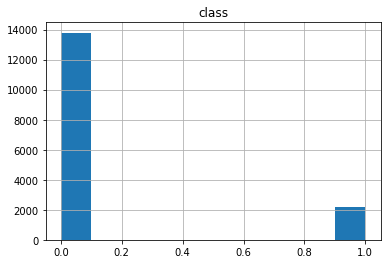

In [13]:
train_data.hist()

In [13]:
train_data.head()

,patient,file,class,source
0,25,acute-respiratory-distress-syndrome-ards-1.jpg,0,cohen
1,26,acute-respiratory-distress-syndrome-ards.jpg,0,cohen
2,27,ards-secondary-to-tiger-snake-bite.png,0,cohen
3,28,pneumocystis-pneumonia-2-PA.png,0,cohen
4,38,F051E018-DAD1-4506-AD43-BE4CA29E960B.jpeg,0,cohen


In [14]:
neg = train_data[train_data['class']==0]
pos = train_data[train_data['class']==1]
neg = neg[0:3000]

training_data = pd.concat([pos,neg])
training_data = training_data.sample(frac=1)

In [15]:
# we should split our training data into training and validation splits 
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(training_data['file'], training_data['class'], test_size=0.30, random_state=42)

In [16]:
# we can 
from torchvision import transforms
transform = transforms.Compose([
transforms.Resize((324, 324)),
transforms.RandomHorizontalFlip(p=0.5),
transforms.RandomVerticalFlip(p=0.5),
transforms.RandomPerspective(),
transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
transforms.ToTensor(),
transforms.Normalize((0.5), (0.5))])

In [17]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from PIL import Image as im

class CovidData(Dataset):
    def __init__(self, X, y, img_dir, transform=None, target_transform=None):
        self.imgs = X.values
        self.img_labels = y.values
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        image = im.fromarray(cv2.imread(img_path))#read_image(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [18]:
training_arr = CovidData(X_train, y_train, 'train', transform = transform)
valid_arr = CovidData(X_test, y_test, 'train', transform=transform)


In [19]:
len(training_arr)

3610

0


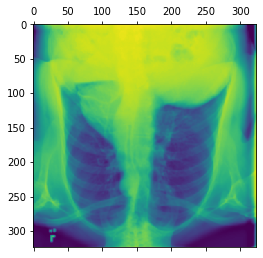

In [20]:
plt.matshow(training_arr[2313][0][0])
print(y_train.values[2313])

In [21]:
from collections import Counter
Counter(y_train)

Counter({0: 2058, 1: 1552})

In [22]:
# defining trainloader and testloader
trainloader = torch.utils.data.DataLoader(training_arr, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(valid_arr, batch_size=128, shuffle=True)

In [23]:
trainloader.dataset[0][0].shape

torch.Size([3, 324, 324])

In [24]:
# defining the model architecture
from torch import nn, optim
import torchvision.models as models


model = models.inception_v3()


/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


In [25]:
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [26]:
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))

In [27]:
# defining the model
#model = Net()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.03)
# defining the loss function
criterion = nn.NLLLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
#print(model)

In [28]:
len(trainloader)

29

In [ ]:
from tqdm import tqdm
losses = []
for i in tqdm(range(10)):
    running_loss = 0
    for images, labels in trainloader:

        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
       # print('passed')
        loss = criterion(output, labels)
        #print(loss)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
        print(loss.item())
    #else:
    print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))
    losses.append(running_loss)
    torch.save(model,  "model_{}.pb".format(i))
    print('saving model!')


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
 plt.plot(losses)

In [ ]:

predictions = []
total_labels = []
count = 0
for images, labels in testloader:
      if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
      out = model(images)

      preds = np.argmax(out.cpu().detach().numpy(), axis = 1)
      true = labels.cpu().detach().numpy()  

      predictions.append(preds)
      total_labels.append(true)    
      count = count+1
      if(count==5):
        break
      print(count)

In [ ]:
# save model
#torch.save(model, 'initial_model.pb')
out = np.concatenate(predictions).ravel()
total_labels = np.concatenate(total_labels).ravel()

print(classification_report(total_labels, out))

In [ ]:
# notice the threshold
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(labels: np.ndarray, predictions: np.ndarray, p: float=0.5) -> ():
    cm = confusion_matrix(labels, predictions > p)
    # you can normalize the confusion matrix

    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('(True Negatives): ', cm[0][0])
    print('(False Positives): ', cm[0][1])
    print('(False Negatives): ', cm[1][0])
    print('(True Positives): ', cm[1][1])
    print('Total Lesions: ', np.sum(cm[1]))

plot_cm(total_labels, out)


In [ ]:
preds = np.argmax(out.cpu().detach().numpy(), axis = 1)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
true = labels.cpu().detach().numpy()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       218
           1       0.00      0.00      0.00        38

    accuracy                           0.85       256
   macro avg       0.43      0.50      0.46       256
weighted avg       0.72      0.85      0.78       256

